In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medium-articles/articles.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
medium_articles = pd.read_csv("../input/medium-articles/articles.csv")
medium_articles.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


Total Number of unique authors : 182


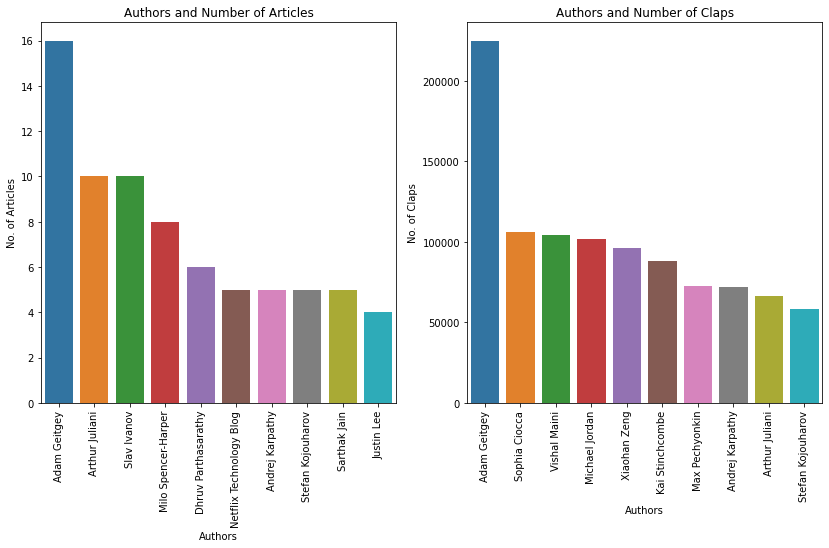

In [4]:
article_text = medium_articles.text
# visualise first article print few words from it
#print("First 1000 words in first article are : \n",article_text[0][:1000])

#total number of author
print(f"Total Number of unique authors : {len(medium_articles.author.unique())}")

#counting the articles of different authors
article_counts = dict()
for author in medium_articles.author:
    article_count = len(medium_articles[medium_articles["author"]==author])
    article_counts[author] = article_count

#sorting the article_counts on the basis of article count
article_counts = dict(sorted(article_counts.items(), key=lambda x: x[1], reverse=True))


#plot histogram of top 10 authors and their article counts
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
sns.barplot(x = list(article_counts.keys())[:10],y=list(article_counts.values())[:10])
plt.title("Authors and Number of Articles")
plt.xlabel("Authors")
plt.ylabel("No. of Articles")
plt.xticks(rotation = 90) 



#counting the total number of claps for each author
def convert_to_num(clap_count):
    if "K" in clap_count:
        if "." in clap_count:
            clap_count = re.sub("\.","",clap_count[:-1])+"00"
        else:
            clap_count = clap_count[:-1]+"000"
    return(int(clap_count))

medium_articles.claps = medium_articles.claps.apply(convert_to_num)

#couting total number of claps for each author
clap_counts = dict()
for author in medium_articles.author:
    clap_count = medium_articles[medium_articles["author"]==author]["claps"]
    clap_counts[author] = sum(clap_count)

#sort clap_counts on the basis of counting of claps
clap_counts = dict(sorted(clap_counts.items(), key=lambda x: x[1], reverse=True))

#plot histogram of top 10 authors and their article counts
plt.subplot(1, 2, 2)
sns.barplot(x = list(clap_counts.keys())[:10],y=list(clap_counts.values())[:10])
plt.title("Authors and Number of Claps")
plt.xlabel("Authors")
plt.ylabel("No. of Claps")
plt.xticks(rotation = 90) 
plt.show()

In [5]:
medium_articles.text = medium_articles.text.apply(lambda t : t.lower())

In [6]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the text data
medium_articles.text = medium_articles.text.apply(lambda x:expand_contractions(x))

In [7]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
print(f"These are the pucntions which string.punctuation consist :  {string.punctuation}")

These are the pucntions which string.punctuation consist :  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [9]:
stop_words = set(stopwords.words('english')) 

def remove_stopwords(article):
    "Return the articel after remvoing stopwords"
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)


#removing stopwords
medium_articles.text = medium_articles.text.apply(remove_stopwords)

#removing Punctuations 
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#removing digits
medium_articles.text = medium_articles.text.apply(lambda x: re.sub('\w*\d\w*','', x))

medium_articles.text[50]

'upd  april      scikit flow merged tensorflow since version  called tensorflow learn tflearn  google released machine learning framework called tensorflow ’ taking world storm   stars github  lot publicity general excitement ai researchers   use something regular problem data scientist may   ai researcher — build interesting problems time   reasonable question  data scientist  already number tools toolbox  r  scikit learn  etc   care yet another framework  answer two part  let ’ start simple example — take titanic dataset kaggle  first  make sure installed tensorflow scikit learn helpful libs  including scikit flow simplifying lot work tensorflow  get dataset code http  githubcomilblackdragontfexamples quick look data  use ipython ipython notebook ease interactive exploration   let ’ test predict survived class  based float variables scikit learn  separate dataset features target  fill na data zeros build logistic regression  predicting training data gives us measure accuracy  cause ’

In [10]:
def remove_extra_marks(article):
    extra_keys = ["’","—","”","“"]
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in extra_keys] 
    return " ".join(filtered_article)
    
medium_articles.text = medium_articles.text.apply(remove_extra_marks)

In [11]:


#printing arbitrary example to visulise clean data
medium_articles.text[50]



'upd april scikit flow merged tensorflow since version called tensorflow learn tflearn google released machine learning framework called tensorflow taking world storm stars github lot publicity general excitement ai researchers use something regular problem data scientist may ai researcher build interesting problems time reasonable question data scientist already number tools toolbox r scikit learn etc care yet another framework answer two part let start simple example take titanic dataset kaggle first make sure installed tensorflow scikit learn helpful libs including scikit flow simplifying lot work tensorflow get dataset code http githubcomilblackdragontfexamples quick look data use ipython ipython notebook ease interactive exploration let test predict survived class based float variables scikit learn separate dataset features target fill na data zeros build logistic regression predicting training data gives us measure accuracy cause properly evaluate model quality test dataset used 

In [12]:
import spacy
nlp = spacy.load('en_core_web_sm')
print(f""" "helps" after lemmztization :  {nlp("helps")[0].lemma_}""")
print(f""" "helping" after lemmztization :  {nlp("helping")[0].lemma_}""")

 "helps" after lemmztization :  help
 "helping" after lemmztization :  help


In [13]:
def lemmatize(text):
    """Return text after performing the lemmztiztion"""
    doc = nlp(text)
    tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])

#lemmatize the articles
medium_articles.text = medium_articles.text.apply(lemmatize)

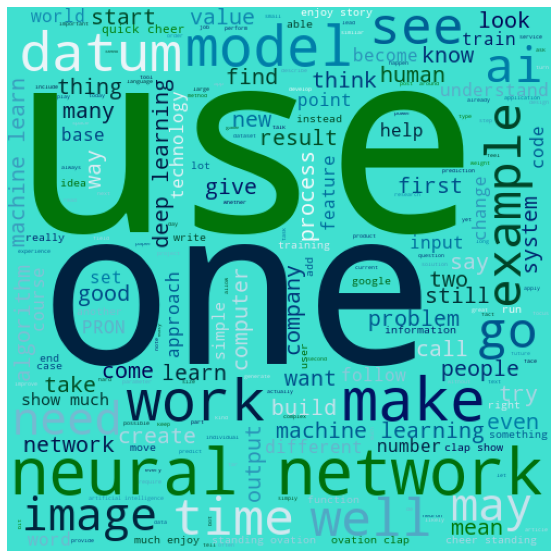

In [14]:
import wordcloud
from wordcloud import WordCloud

#combine all the articles
article_data = ""
for article in medium_articles.text:
    article_data = article_data+" "+article

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(article_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [15]:
#tokenize articles
tokeize_article = medium_articles.text.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[("'", 8),
 ('-PRON-', 3),
 ('able', 1),
 ('abruptly', 1),
 ('acceptance', 1),
 ('access', 1),
 ('accident', 1),
 ('accord', 2),
 ('achieve', 2),
 ('adage', 1),
 ('advantage', 1),
 ('agenda', 1),
 ('ageold', 1),
 ('ago', 2),
 ('ai', 3),
 ('aim', 1),
 ('alive', 1),
 ('allow', 1),
 ('allrounder', 1),
 ('along', 1),
 ('also', 1),
 ('alternative', 1),
 ('amount', 1),
 ('analyze', 1),
 ('another', 5),
 ('answer', 1),
 ('anticipate', 1),
 ('anticlimax', 1),
 ('anyone', 1),
 ('anything', 2),
 ('app', 12),
 ('applied', 1),
 ('approach', 3),
 ('arcane', 2),
 ('area', 2),
 ('arise', 1),
 ('around', 3),
 ('asay', 1),
 ('ask', 1),
 ('aspect', 1),
 ('assumption', 1),
 ('attention', 1),
 ('automate', 2),
 ('available', 1),
 ('average', 1),
 ('away', 2),
 ('back', 3),
 ('baffle', 1),
 ('basic', 1),
 ('basically', 1)]

In [16]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"word" + 0.008*"vector" + 0.008*"ai" + 0.007*"make" + 0.007*"cluster" '
  '+ 0.007*"go" + 0.006*"system" + 0.006*"human" + 0.006*"use" + 0.006*"one"'),
 (1,
  '0.020*"network" + 0.015*"use" + 0.014*"neural" + 0.009*"learn" + '
  '0.009*"layer" + 0.008*"function" + 0.008*"one" + 0.008*"model" + '
  '0.007*"neuron" + 0.006*"datum"'),
 (2,
  '0.019*"member" + 0.015*"music" + 0.012*"recommendation" + 0.011*"song" + '
  '0.010*"artwork" + 0.010*"github" + 0.010*"track" + 0.009*"star" + '
  '0.009*"netflix" + 0.009*"spotify"'),
 (3,
  '0.007*"ai" + 0.006*"machine" + 0.006*"like" + 0.006*"people" + 0.006*"de" + '
  '0.005*"intelligence" + 0.005*"one" + 0.005*"use" + 0.005*"new" + '
  '0.004*"human"'),
 (4,
  '0.019*"human" + 0.012*"may" + 0.011*"→" + 0.010*"simulation" + 0.010*"u" + '
  '0.009*"bot" + 0.009*"value" + 0.008*"chatbot" + 0.008*"process" + '
  '0.007*"conversation"'),
 (5,
  '0.011*"man" + 0.011*"woman" + 0.008*"attract" + 0.007*"face" + '
  '0.006*"facial" + 0.005*

In [18]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.177195  0.014580       1        1  29.895388
3      0.056950  0.051690       2        1  27.827761
6      0.136461  0.021134       3        1  10.616594
9      0.139273  0.015702       4        1  10.105494
7      0.061315 -0.104703       5        1   5.972034
0     -0.010515  0.085314       6        1   4.945688
8     -0.058855 -0.243562       7        1   4.001527
5     -0.052301  0.085600       8        1   3.561281
4     -0.196320  0.099502       9        1   2.256390
2     -0.253205 -0.025256      10        1   0.817844, topic_info=          Term         Freq        Total Category  logprob  loglift
1429     image  1554.000000  1554.000000  Default  30.0000  30.0000
362    machine  1621.000000  1621.000000  Default  29.0000  29.0000
782   learning  1694.000000  1694.000000  Default  28.0000  28.0000
722     course   548.000000   548.000000  Default  27.0000  27.0000
1039   network  2792.000000  2792.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2403  discover     9.138170   115.224534  Topic10  -5.7017   2.2718
1545    vector    11.576001   351.049483  Topic10  -5.4652   1.3943
1034     model    11.622769  1571.059651  Topic10  -5.4611  -0.1003
1450   million     8.613375   165.795208  Topic10  -5.7608   1.8488
2361    source     7.975153   136.463434  Topic10  -5.8378   1.9665

[725 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.204750    '
0         2  0.611484    '
0         3  0.077473    '
0         5  0.022135    '
0         8  0.047037    '
...     ...       ...  ...
2299      1  0.043686    —
2299      2  0.908672    —
2299      3  0.043686    —
2300      1  0.974452    •
676       9  0.993438    →

[1836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 7, 10, 8, 1, 9, 6, 5, 3])

In [19]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -7.909129498402046

Coherence Score:  0.4110839831146874
